# Applying CHs segmentation model

In this notebook we will apply CNN model for CHs segmentation in SDO/AIA 193 Angstrom images in 1K resolution obtained from [SunInTime](https://suntoday.lmsal.com/suntoday/) website.

General imports:

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from sunpy.visualization.colormaps import color_tables as ct
sdoaia193 = ct.aia_color_table(193)

sys.path.append("..")
from helio.helio import HelioBatch, FilesIndex, BatchSampler, detect_edges, u_net

First we load a model to make it ready for segmentation:

In [16]:
PATH_TO_SAVED_MODEL = "../../model_dumps/h_seg_model_24.ckpt"

image_shape = (256, 256, 1)

depth = 4 #Depth of u-net network
init_filters = 24 #Number of filters int the first conv layer

config = tf.ConfigProto()
graph = tf.Graph()
with graph.as_default():
    inputs = tf.placeholder('float', shape=(None, ) + image_shape, name='inputs')
    is_training = tf.placeholder(tf.bool, name='is_training')

    predict = u_net(inputs, depth=depth, init_filters=init_filters,
                    output={'layout': 'ca', 'filters': 1, 'activation': tf.nn.sigmoid},
                    is_training=is_training, verbose=1)
    
    sess = tf.Session(config=config)
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    saver.restore(sess, PATH_TO_SAVED_MODEL)

INFO:tensorflow:Restoring parameters from ../../model_dumps/h_seg_model_24.ckpt


Index files we want to process: 

In [3]:
images = FilesIndex(img='../../aia193_images/*jpg')
images.head()

,img
FilesIndex,
20181220_234500,../../aia193_images\20181220_234500.jpg
20181221_234500,../../aia193_images\20181221_234500.jpg
20181222_234500,../../aia193_images\20181222_234500.jpg
20181223_234500,../../aia193_images\20181223_234500.jpg
20181224_234500,../../aia193_images\20181224_234500.jpg


Preprocessing includes reading data and resizing to output shape 256x256:

In [6]:
def preprocess(batch):
    return (batch.load('img', as_gray=True)
            .resize(src='img', output_shape=(256, 256), preserve_range=True))

Initialize a batch sampler that helps to process possible large datasets:

In [7]:
batch_sampler = BatchSampler(images, batch_size=10)

Run inference on batches:

In [8]:
for ids in tqdm(batch_sampler):
    batch = preprocess(HelioBatch(ids))
    x = np.array([np.atleast_3d(i) for i in batch.img])
    res = sess.run(predict, feed_dict={inputs: x, is_training: False})
    batch.results = res[..., 0]
    batch.dump(src='results', path='./tmp', format='npz')

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:26<00:00,  4.49s/it]


Now let's load and show sample image and predicted mask:

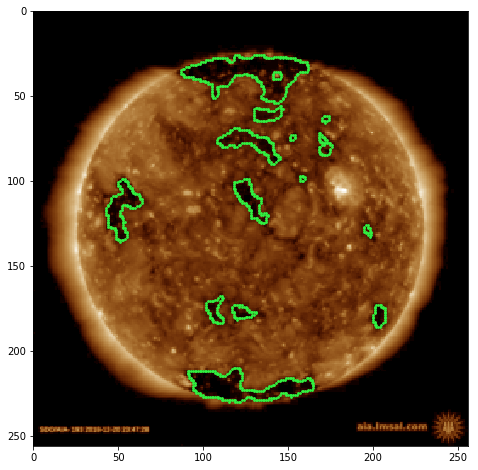

In [10]:
pred = FilesIndex(mask='./tmp/*npz')
index = images.index_merge(pred)

batch = (HelioBatch(index.iloc[[0]]).load(('img', 'mask'), as_gray=True)
         .resize(src='img', output_shape=(256, 256), preserve_range=True))

batch.show(0, image='img', mask='mask', figsize=(8, 8), cmap=sdoaia193, s=3, color='#30f241')

Done!